In [1]:
#%matplotlib widget

In [2]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from dPCA import dPCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
#import pca_tools
seed=2024

### Define functions

In [3]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [4]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [5]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [6]:
def get_fr_samples(sp,sample_id,start,end,samples):
    # parameters
    n_trials = 10
    win=50
    # Check fr
    ms_fr=np.nanmean(sp[:,start:end])*1000>5
    if not ms_fr:
        return None
    # Average spikes
    avg_sample = firing_rate.moving_average(sp, win=win, step = 1)
    fr_samples = []
    for s_id in samples:
        sample_fr = avg_sample[np.where(sample_id==s_id,True,False),start:end]
        # Check number of trials
        if sample_fr.shape[0]< n_trials:
            return None
        fr_samples.append(sample_fr[:n_trials])
    return np.array(fr_samples)


In [7]:
def get_neuron_sample_fr(path,time_before,start,end,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<50:
        return {'fr':None}
    sample_id = neu_data.sample_id[mask]
    fr_samples = get_fr_samples(sp_sample_on,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [8]:
def get_neuron_sample_test1_fr(path,time_before,start,end,end_test,n_test,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= 0,
    )
    if np.any(mask_sample != mask_test1):
        print(path)
        return 
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_neu = neu_data.sample_id[mask_test1]==0
    mask_match_neu = np.logical_or(mask_match,mask_neu)
    if np.sum(mask_match_neu)<20:
        return {'fr':None}
 
    sp=np.concatenate((sp_sample_on[mask_match_neu,:time_before+450+200],sp_test1_on[mask_match_neu,:end_test+400]),axis=1)

    sample_id = neu_data.sample_id[mask_test1][mask_match_neu]
    fr_samples = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

### Read data

In [34]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [35]:
area='lip'
neu_path = basepath+'/session_struct/'+area+'/neurons/*neu.h5'
path_list = glob.glob(neu_path)

In [36]:
# Load data
n_test=0
time_before=500
start=-200
end_test = n_test*450+200
end=450+200+200#+end_test

idx_start = time_before + start 
idx_end = time_before+end

In [37]:
T=end-start
T

1050

In [38]:
200+450+200+200

1050

In [39]:
rng = np.random.default_rng(seed=seed)
data = Parallel(n_jobs = -1)(delayed(get_neuron_sample_fr)(path,time_before,start,end,rng) for path in tqdm(path_list))

0it [00:00, ?it/s]


In [ ]:
neurons_fr = []
N = 0
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        N+=1
        neurons_fr.append(fr)
#to_python_hdf5(dat=neurons_fr, save_path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area+'_win50_test'+str(n_test)+'_dpca.h5')

In [ ]:
N

200

In [ ]:
# neurons_fr_read=from_python_hdf5(load_path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area+'_win50_test'+str(n_test)+'_dpca.h5')
# neurons_fr = []
# for asc in neurons_fr_read:
#     fr = asc["fr"]
#     if fr is not None:
#         fr_concat = np.concatenate(fr,axis=0)
#         neurons_fr.append(fr_concat)

In [ ]:
neurons_fr = np.array(neurons_fr)#.reshape(-1,1050)
neurons_fr =np.transpose(neurons_fr,(2,0,1,3))
neurons_fr.shape

(10, 200, 5, 1050)

In [ ]:
neurons_fr.shape

(10, 200, 5, 1050)

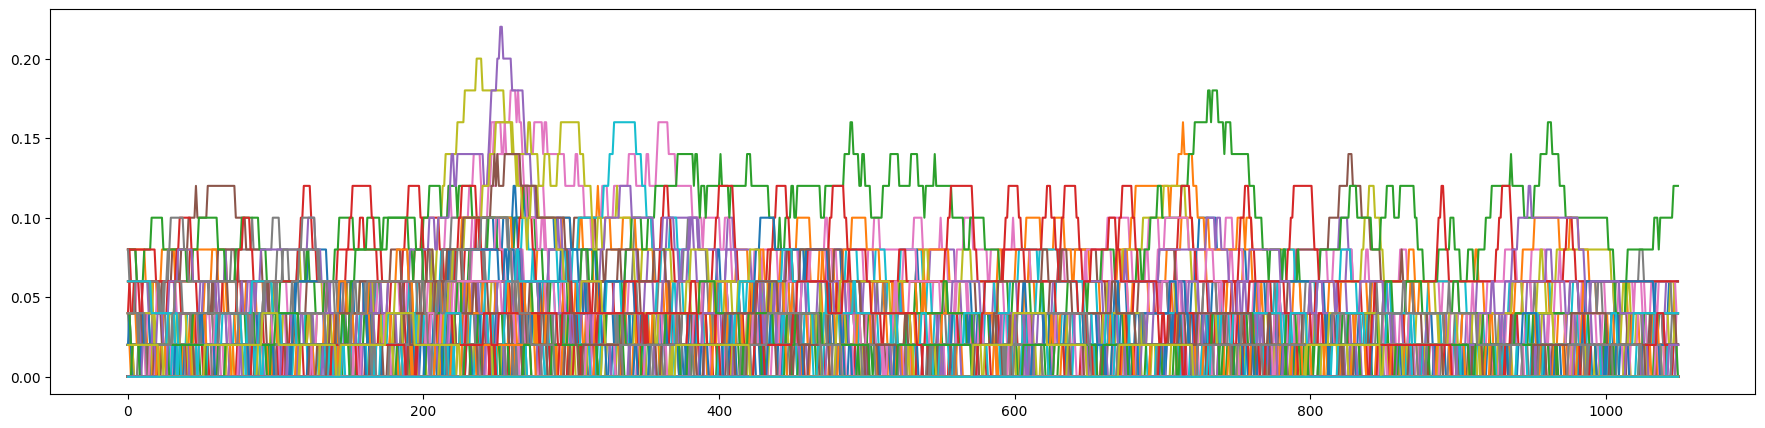

In [ ]:
plt.subplots(figsize=(22,5))
_=plt.plot(neurons_fr[0,:,0,:1200].T)

In [ ]:
neurons_fr.shape

(10, 200, 5, 1050)

In [ ]:
# trial-average data
R = np.mean(neurons_fr,0)

# center data
R -= np.mean(R.reshape((N,-1)),1)[:,None,None]

In [ ]:
dpca = dPCA.dPCA(labels='st',regularizer='auto',n_components=20)
dpca.protect = ['t']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


In [ ]:
Z = dpca.fit_transform(R,neurons_fr)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.013016111155156117
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


[Text(0.5, 1.0, '1st mixing component')]

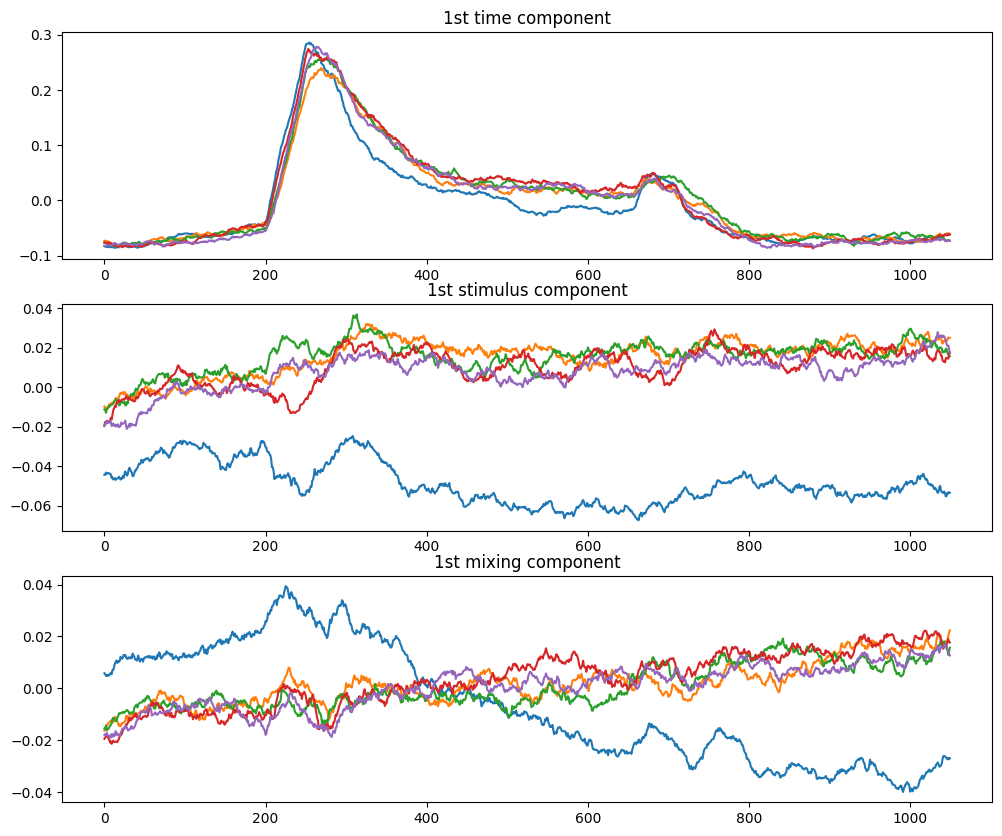

In [ ]:
time = np.arange(T)

f,ax=plt.subplots(3,1,figsize=(12,10))
#plt.subplot(311,title='1st time component')

for s in range(5):
    ax[0].plot(time,Z['t'][0,s])
ax[0].set(title='1st time component')
    
#plt.subplot(312,title='1st stimulus component')

for s in range(5):
    ax[1].plot(time,Z['s'][0,s])
ax[1].set(title='1st stimulus component') 
    
#plt.subplot(313,title='1st mixing component')

for s in range(5):
    ax[2].plot(time,Z['st'][0,s])
ax[2].set(title='1st mixing component')


In [ ]:
dpca.explained_variance_ratio_

{'s': [0.0314713553672331,
  0.004778131241571722,
  0.0018155614654729606,
  0.0005475033946567094,
  3.264854066822565e-34,
  1.399646837991588e-34,
  2.269595723895965e-34,
  2.5553267364905537e-34,
  2.8355244215680716e-34,
  6.341906015663163e-35,
  3.109571079589469e-35,
  5.03752740576111e-35,
  5.5808040351007365e-34,
  1.661833518674644e-34,
  4.970331678369121e-35,
  8.195463459508142e-35,
  1.3929163881368825e-34,
  2.5085179984049883e-35,
  4.044309314147012e-35,
  1.2561795625867624e-34],
 't': [0.34118183610979474,
  0.06796872545270813,
  0.02197078999588249,
  0.014955523160986514,
  0.006744183537296572,
  0.004216499731815365,
  0.000797669659896674,
  0.0004861856605512386,
  0.00019790405746421925,
  9.189553231275835e-05,
  4.6807048192463164e-05,
  3.5599888010191383e-05,
  2.3639441332104456e-05,
  1.3195866166068492e-05,
  1.1608377995225057e-05,
  7.0632662558355996e-06,
  4.732378412530638e-06,
  4.7873984261451375e-06,
  3.6659290780682744e-06,
  2.5108643205